# Step 1: Import

In [1]:
import copy
import networkx as nx
import heapq
import math
from scipy.spatial.distance import euclidean, cityblock
from IPPlanerBase import PlanerBase
import numpy as np

# Step 2: Class A-Star

In [2]:
class AStar(PlanerBase):
    def __init__(self, collChecker=0):
        """Contructor:

        Initialize all necessary members"""

        super(AStar, self).__init__(collChecker)
        self.graph = nx.DiGraph()  # = CloseList
        self.openList = []  # (<value>, <node>)

        self.goal = []
        self.goalFound = False

        self.limits = self._collisionChecker.getEnvironmentLimits()

        self.w = 0.5
        return

    def _getNodeID(self, pos):
        """Compute a unique identifier based on the position"""

        nodeId = "-"
        for i in pos:
            nodeId += str(i)+"-"
        return nodeId

    def planPath(self, startList, goalList, config):
        """

        Args:
            start (array): start position in planning space
            goal (array) : goal position in planning space
            config (dict): dictionary with the needed information about the configuration options

        Example:

            config["w"] = 0.5
            config["heuristic"] = "euclid"

        """
        # 0. reset
        self.graph.clear()

        # 1. check start and goal whether collision free (s. BaseClass)
        checkedStartList, checkedGoalList = self._checkStartGoal(
            startList, goalList)

        # 2.
        self.w = config["w"]
        self.heuristic = config["heuristic"]
        self.dis = config['dis']
        self.digit = config['digit']
        self.goal = checkedGoalList[0]
        self._addGraphNode(checkedStartList[0])

        currentBestName = self._getBestNodeName()
        #print('currenBestName' + currentBestName)
        ###################################################################################################################################
        ##new###
        self.addaptive_Discretization = self._addapitveDiscretization(checkedStartList,checkedGoalList,self.dis)
        print(self.addaptive_Discretization)
        ###################################################################################################################################
        breakNumber = 0
        while currentBestName:
            if breakNumber > 10000/(self.dis*self.dis):  # abort criterion is increased, since no path is otherwise found with a finer grid
                break

            breakNumber += 1

            currentBest = self.graph.nodes[currentBestName]
            # print('currenBest:', currentBest)

            if currentBest["pos"] == self.goal:
                self.solutionPath = []
                self._collectPath(currentBestName, self.solutionPath)
                self.goalFound = True
                break

            currentBest["status"] = 'closed'
            print('currentBest["pos"]: ', currentBest["pos"])
            if self._collisionChecker.pointInCollision(currentBest["pos"]):
                currentBest['collision'] = 1
                currentBestName = self._getBestNodeName()
                # print(currentBestName)
                continue

            self.graph.nodes[currentBestName]['collision'] = 0

            # handleNode merges with former expandNode
            self._handleNode(currentBestName, self.addaptive_Discretization,self.digit)
            
            currentBestName = self._getBestNodeName()

        if self.goalFound:
            return self.solutionPath
        else:
            return None





    def _insertNodeNameInOpenList(self, nodeName):
        """Get an existing node stored in graph and put it in the OpenList"""
        heapq.heappush(self.openList, (self._evaluateNode(nodeName), nodeName))

    def _addGraphNode(self, pos, fatherName=None):
        """Add a node based on the position into the graph. Attention: Existing node is overwritten!"""
        self.graph.add_node(self._getNodeID(pos), pos=pos, status='open', g=0)

        if fatherName != None:
            self.graph.add_edge(self._getNodeID(pos), fatherName)
            self.graph.nodes[self._getNodeID(
                pos)]["g"] = self.graph.nodes[fatherName]["g"] + 1

        self._insertNodeNameInOpenList(self._getNodeID(pos))

    def _setLimits(self, lowLimit, highLimit):
        """ Sets the limits of the investigated search space """
        assert (len(lowLimit) == len(highLimit) == self.dim)
        self.limits = list()
        for i in range(self.dim):
            self.limits.append([lowLimit[i], highLimit[i]])
        return

    def _getBestNodeName(self):
        """ Returns the best name of best node """
        return heapq.heappop(self.openList)[1]

    def _handleNode(self, nodeName, dis, digit): 
        """Generats possible successor positions in all dimensions"""
        result = []
        node = self.graph.nodes[nodeName]
        print('node', node)
        for i in range(len(node["pos"])):
            print('first loop ', i)
            for u in [-self.addaptive_Discretization[i],self.addaptive_Discretization[i]]: # for u in [- dis[i], dis[i]]: #
                newPos = copy.copy(node["pos"])
                newPos[i] += u
                newPos[i] = round(newPos[i] , digit) #numerische Berechnungsfehler
                

                print('u: ', u, 'newPos[i]: ', newPos[i])
                if not self._inLimits(newPos):
                    continue
                try:
                    # Do not do reopening! If node already in graph do not add it... Concequences?
                    self.graph.nodes[self._getNodeID(newPos)]
                    continue
                except:
                    pass

                self._addGraphNode(newPos, nodeName)
                print('newPos: ', newPos, 'nodeName: ', nodeName)
            print('END \n\n')
        return result

    def _computeHeuristicValue(self, nodeName):
        """ Computes Heuristic Value: Manhattan Distance """

        result = 0
        node = self.graph.nodes[nodeName]
        if self.heuristic == "euclidean":
            return euclidean(self.goal, node["pos"])
        else:
            return cityblock(self.goal, node["pos"])

    def _evaluateNode(self, nodeName):
        node = self.graph.nodes[nodeName]
        return self.w * self._computeHeuristicValue(nodeName) + (1 - self.w) * node["g"]

    def _collectPath(self, nodeName, solutionPath):

        fathers = list(self.graph.successors(nodeName))
        # print len(fathers)
        if len(fathers) == 1:
            self._collectPath(fathers[0], solutionPath)
        elif len(fathers) == 0:
            solutionPath.append(nodeName)
            return
        else:
            raise Exception(
                "not suitable numbers of fathers = {}.... please check".format(len(fathers)))
        solutionPath.append(nodeName)
        return

    def _inLimits(self, pos):
        result = True
        for i, limit in enumerate(self.limits):
            if pos[i] < limit[0] or pos[i] > limit[1]:
                result = False
                break
        return result


    
    def _addapitveDiscretization(self,checkedStartList,checkedGoalList,maximum_discretization):

        addapitve_discretization = [] 
        
        for n in range(len(checkedStartList[0])):

            discretization = maximum_discretization
            distance = checkedStartList[0] [n] - checkedGoalList [0] [n] # distance between startpoint an endpoint (1 Dimension per Iteration)
            ratio = distance/maximum_discretization

            "checks how many decimal places the ratio has"
            try:
                decimal_places_ratio = len(str(ratio)[str(ratio).index('.')+1:])
            except:
                decimal_places_ratio = 0

            

            "checks how many decimal places the maximum_discretization has"   

            try:
                decimal_places_discretization = len(str(maximum_discretization)[str(maximum_discretization).index('.')+1:])
            except:
                decimal_places_discretization = 0


            "the subtractor is a decimal number of the power of ten, which is always one decimal place smaller than the discretization."
            subtractor = 1/(10**(decimal_places_discretization+1))


            "the variable status is only used for the while loop"
            status = True

            """
            If the variable ratio has no more decimal places, it must be possible to reach the target with the given discretization.
            However, if this is not the case, the discretization is reduced until this is possible.
            """

            while status:

                if decimal_places_ratio == 0:
                    break

                else:

                    discretization = discretization -subtractor # the discretization is reduced
                    discretization = round(discretization,decimal_places_discretization+1) # must be rounded due to numerical errors
                    #print('discretization',discretization)
                    ratio = np.divide(distance,discretization) # ratio is calculated with new discretization
                    #print('ratio', ratio)

                    """
                    The variable difference is the abort criterion. 
                    This is calculated from the difference of the variable ratio and ration_round.
                    If the variable difference is zero, the variable ratio must be an integer 
                    because the variable ratio_round is always an integer
                    """
                    ratio_round = round(ratio,0)
                    difference = ratio - ratio_round
                    #print('difference',difference)

                    if difference == 0:
                        break

            addapitve_discretization.append(discretization)
            print(discretization)
        
        return addapitve_discretization
            



# Step 3: A-Star-Visualize

In [3]:
def aStarVisualize(planner, solution, ax = None, nodeSize = 300):
    graph = planner.graph
    collChecker = planner._collisionChecker
    # get a list of positions of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    color = nx.get_node_attributes(graph,'color')
    
    # get a list of degrees of all nodes
    #degree = nx.degree_centrality(graph)
    
    # draw graph (nodes colorized by degree)
    open_nodes = [node for node,attribute in graph.nodes(data=True) if attribute['status']=="open"]
    draw_nodes = nx.draw_networkx_nodes(graph, pos, node_color='#FFFFFF', nodelist=open_nodes, ax = ax, node_size=nodeSize)
    draw_nodes.set_edgecolor("b")
    open_nodes = [node for node,attribute in graph.nodes(data=True) if attribute['status']=="closed"]
    draw_nodes = nx.draw_networkx_nodes(graph, pos, node_color='#0000FF', nodelist=open_nodes, ax = ax, node_size=nodeSize)
    #nx.draw_networkx_nodes(graph, pos,  cmap=plt.cm.Blues, ax = ax, node_size=nodeSize)
    nx.draw_networkx_edges(graph,pos,
                               edge_color='b',
                               width=3.0
                            )
    
    collChecker.drawObstacles(ax)
    
    # draw nodes based on solution path
    Gsp = nx.subgraph(graph,solution)
    nx.draw_networkx_nodes(Gsp,pos,
                            node_size=nodeSize,
                             node_color='g')
        
    # draw edges based on solution path
    nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10,arrows=True)
 
    nx.draw_networkx_nodes(graph,pos,nodelist=[solution[0]],
                           node_size=300,
                           node_color='#00dd00',  ax = ax)
    nx.draw_networkx_labels(graph,pos,labels={solution[0]: "S"},  ax = ax)


    nx.draw_networkx_nodes(graph,pos,nodelist=[solution[-1]],
                                   node_size=300,
                                   node_color='#DD0000',  ax = ax)
    nx.draw_networkx_labels(graph,pos,labels={solution[-1]: "G"},  ax = ax)


# Step 4: Test

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point, Polygon, LineString
from IPEnvironment import CollisionChecker

# Definition of a testing environment
trapField = dict()
trapField["obs1"] =   LineString([(6, 18), (6, 8), (16, 8), (16,18)]).buffer(1)

environment = CollisionChecker(trapField)


start = [[16.3,20]]
goal  = [[2.6,3.2]]

# AStar
astar = AStar(environment)

# To know what is part on the config please consult the documentation of planPath
astarConfig = dict()
astarConfig["w"] = 0.5
astarConfig["heuristic"]  = "euclidean"
astarConfig["dis"]  = 0.5
astarConfig["digit"]  = 2


solution = astar.planPath(start, goal, astarConfig)
print(astar.graph)


0.1
0.48
[0.1, 0.48]
currentBest["pos"]:  [16.3, 20]
node {'pos': [16.3, 20], 'status': 'closed', 'g': 0, 'collision': 0}
first loop  0
u:  -0.1 newPos[i]:  16.2
newPos:  [16.2, 20] nodeName:  -16.3-20-
u:  0.1 newPos[i]:  16.4
newPos:  [16.4, 20] nodeName:  -16.3-20-
END 


first loop  1
u:  -0.48 newPos[i]:  19.52
newPos:  [16.3, 19.52] nodeName:  -16.3-20-
u:  0.48 newPos[i]:  20.48
newPos:  [16.3, 20.48] nodeName:  -16.3-20-
END 


currentBest["pos"]:  [16.3, 19.52]
node {'pos': [16.3, 19.52], 'status': 'closed', 'g': 1, 'collision': 0}
first loop  0
u:  -0.1 newPos[i]:  16.2
newPos:  [16.2, 19.52] nodeName:  -16.3-19.52-
u:  0.1 newPos[i]:  16.4
newPos:  [16.4, 19.52] nodeName:  -16.3-19.52-
END 


first loop  1
u:  -0.48 newPos[i]:  19.04
newPos:  [16.3, 19.04] nodeName:  -16.3-19.52-
u:  0.48 newPos[i]:  20.0
newPos:  [16.3, 20.0] nodeName:  -16.3-19.52-
END 


currentBest["pos"]:  [16.2, 20]
node {'pos': [16.2, 20], 'status': 'closed', 'g': 1, 'collision': 0}
first loop  0
u:  

# Step 5: Visualize the result

/home/sebastian/.local/lib/python3.10/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


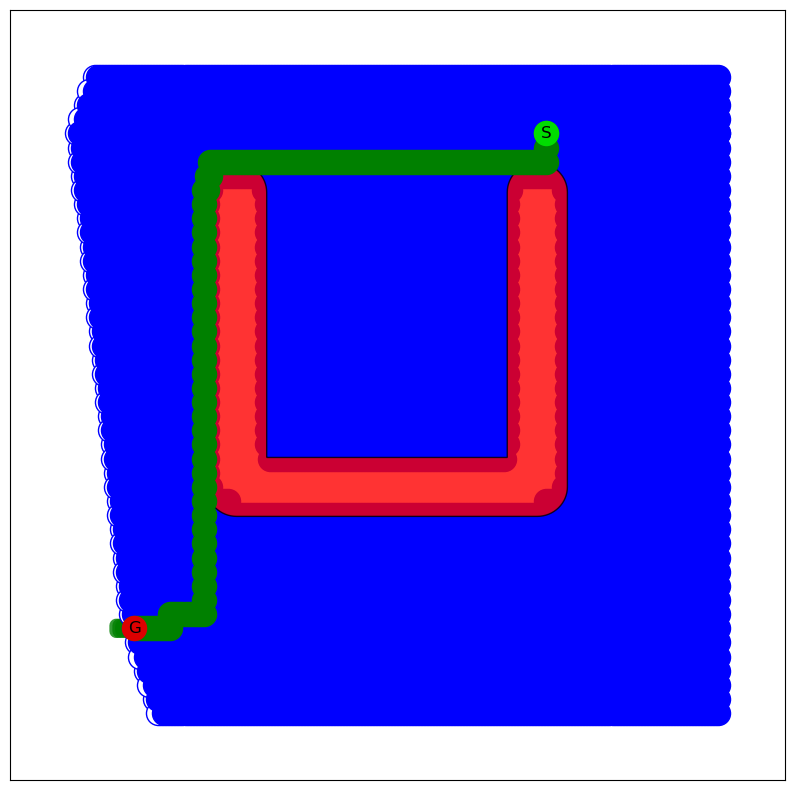

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
aStarVisualize(astar, solution, ax = ax)